<font size=5> This document includes or references data provided by J.P. Morgan. </font>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

sns.set_style("whitegrid")
blue, = sns.color_palette("muted", 1)

In [ ]:
JPfraud_full = pd.read_csv("../data/fraud_payment_data")
JPfraud_full

In [ ]:
# Removing $0 transactions, which contain no fraud labels
JPfraud_full = JPfraud_full[JPfraud_full.USD_amount > 0].reset_index(level=0,drop=True)

In [ ]:
len(JPfraud_full[JPfraud_full.USD_amount == 0])

In [ ]:
JPfraud_full = JPfraud_full.drop(columns=['Sender_lob'],axis=1)
JPfraud_full['timestamp'] = pd.to_datetime(JPfraud_full['Time_step'],format='%Y-%m-%d %H:%M:%S')
JPfraud_full = JPfraud_full.drop(columns=['Time_step'])
JPfraud_full.insert(0,'timestamp',JPfraud_full.pop('timestamp'))
JPfraud_full

In [ ]:
JPfraud = JPfraud_full
JPfraud

In [ ]:
type(JPfraud_full.timestamp.iloc[12345])

In [ ]:
len(set(JPfraud_full.Sender_Account.unique()).union(set(JPfraud_full.Bene_Account.unique())))

In [ ]:
JPfraud.Transaction_Type.value_counts()

In [ ]:
len(set(JPfraud_full.Sender_Account.unique()).union(set(JPfraud_full.Bene_Account.unique())))

In [ ]:
JPfraud.Label.value_counts(normalize=True)

In [ ]:
print(JPfraud.Sender_Id.value_counts())
print()
print(JPfraud.Bene_Id.value_counts())

In [ ]:
# Do unique accounts have multiple Sender or Beneficiary countries?
sender_pairs = JPfraud[['Sender_Id','Sender_Country']].dropna().drop_duplicates()
sender_pairs.sort_values(by='Sender_Id',inplace=True,ascending=True)
sender_pairs = sender_pairs.reset_index(drop=True)
sender_pairs

In [ ]:
sender_pairs[sender_pairs.duplicated(subset='Sender_Id',keep=False)]

In [ ]:
len(JPfraud.Transaction_Id.unique())

<font size=8>Checking for which transactions have NaNs </font>

In [ ]:
JPfraud.info()

In [ ]:
JPfraud.isna().sum()

In [ ]:
# Indicating only depositing transactions have NaN's for Sender_Id
JPfraud[((JPfraud.Sender_Id.isnull()) & ~((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK')))]

In [ ]:
print('Number of DEPOSIT-CASH, DEPOSIT-CHECK transactions', len(JPfraud[((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK'))]))
print('Number of NaNs in Sender_Id for DEPOSIT-CASH, DEPOSIT-CHECK transactions', len(JPfraud[((JPfraud.Sender_Id.isna()) & ((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK')))]))

In [ ]:
print('Number of WITHDRAWAL, EXCHANGE transactions', len(JPfraud[((JPfraud.Transaction_Type == 'WITHDRAWAL') |
                                             (JPfraud.Transaction_Type == 'EXCHANGE'))]))
print('Number of nulls in Bene_Id for WITHDRAWAL, EXCHANGE transactions', len(JPfraud[((JPfraud.Bene_Id.isnull()) &
                                                                                            ((JPfraud.Transaction_Type == 'WITHDRAWAL') |
                                                                                             (JPfraud.Transaction_Type == 'EXCHANGE')))]))

<font size=4> **Conclusion:** *There's not any "missing data." Deposits (DEPOSIT-CASH, DEPOSIT-CHECK) only have Beneficiary account identifications, and withdrawals/exchanges only have Sender account identifications.*</font>

<font size=6> Comparing transaction amount and number of fraudulent transactions detected </font>

In [ ]:
trans_types = JPfraud.Transaction_Type.unique()
fraud_number = np.zeros(len(trans_types))
non_fraud_number = np.zeros(len(trans_types))

for i, trans in enumerate(trans_types):
    fraud_number[i] = JPfraud.loc[JPfraud.Transaction_Type == trans].Label.sum()
    non_fraud_number[i] = len(JPfraud[JPfraud.Label == 0].loc[JPfraud.Transaction_Type == trans])

In [ ]:
plt.figure()

plt.bar(trans_types, fraud_number, edgecolor='black', color='firebrick')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of fraud transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)),trans_types,rotation=75)
plt.title('Number of Fraud Transactions by Type',fontsize=14)
plt.tight_layout()
plt.savefig('Fraud_number_vs_transaction_types.png')
plt.show()

In [ ]:
plt.figure()

w = 0.4

plt.bar(np.arange(len(trans_types))-w/2, non_fraud_number, label='non-fraud', edgecolor='black', width=w)
plt.bar(np.arange(len(trans_types))+w/2, fraud_number, alpha = 0.5, color='red', width=w,
        label='fraud', edgecolor='darkred', linewidth=1.2)
plt.hlines(y=fraud_number[1]+2038, xmin=-0.5, xmax=len(trans_types)-0.5,
           linewidth=0.75, color='red', linestyle='--')
plt.vlines(x=1.2, ymin=fraud_number[1], ymax=245000,
           linewidth=0.75, color='red', linestyle='-')
plt.text(0.25,250000, 'Highest fraud count: 7935', fontsize=8, color='red')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)), trans_types, rotation=75)
plt.title('Number of Transaction Types: Fraud vs. Non-Fraud',fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('fraud_and_non-fraud_vs_transaction_types.png')
plt.show()

In [ ]:
print('Max USD amount:', JPfraud.USD_amount.max())
print('Min USD amount:', JPfraud.USD_amount.min())

In [ ]:
JPfraud.loc[JPfraud.Label == 1].USD_amount.describe()

In [ ]:
JPfraud.loc[JPfraud.Label == 0].USD_amount.describe()

In [ ]:
bin_labels = []
for i in np.arange(40):
    bin_labels.append(str(i*500) + '-' + str(i*500 + 500))

print(bin_labels)
print()
print(len(bin_labels))

In [ ]:
plt.figure(figsize=(12,6))
JPfraud.loc[JPfraud.USD_amount < 2500].USD_amount.plot.hist(bins=10, density=True)
plt.show()

plt.figure(figsize=(12,6))
JPfraud[JPfraud.Label == 1].loc[JPfraud.USD_amount < 2500].USD_amount.plot.hist(bins=10, density=True)
plt.show()

<font size=6> Distribution of time </font>

In [ ]:
plt.figure()
JPfraud_timeplot = JPfraud.sample(100000,random_state=12345)
plt.scatter(JPfraud_timeplot.index,JPfraud_timeplot.timestamp,marker='o',facecolor='None',edgecolor='blue')
plt.xlim([0,2000])
plt.ylim([dt.datetime(2022,3,15,0,0,0),dt.datetime(2022,4,1,0,0,0)])
plt.show()

In [ ]:
plt.figure()
JPfraud_timeplot2 = JPfraud.sample(100000,random_state=12345)
plt.scatter(JPfraud_timeplot2.index,JPfraud_timeplot2.timestamp,marker='o',facecolor='None',edgecolor='blue')
plt.xlim([2300,4250])
plt.ylim([dt.datetime(2022,3,30,0,0,0),dt.datetime(2022,4,17,0,0,0)])
plt.show()

In [ ]:
JPfraud.timestamp.value_counts().head(40)

<font size=6> Behavioral Features </font>

**Goal:** Identify patterns from a client’s transaction history.

Transaction Amount Patterns:
<ul><li> Average transaction amount per client </li>
<li> Deviations from typical amounts (outliers) </li>
</ul>

Transaction Timing Patterns:
<ul>
 <li>  Unusual activity by local time (time zone outliers for the client) </li>
 <li> Time between consecutive transactions, </li>
 <li> Recipient Patterns: Number of unique recipients per sender (potential pattern for laundering) </li>
</ul>

<font size=6> Attempting rolling day stats</font>

In [ ]:
rolling_period = '180D'
min_obs = 3

In [26]:
# Calculates time between previous transaction for each of seller, beneficiary
# (The mask.....etc code sets the sender_time_btwn, bene_time_btwn feature to 0 (of timedelta type)
# for the first occurrence an account appears. NaT's are still placed where a Sender_Account or
# Bene_Account entry is NaN.)

JPfraud['sender_time_btwn'] = (JPfraud.groupby('Sender_Account')['timestamp'].diff()
                                      .mask(JPfraud.groupby('Sender_Account')['timestamp'].cumcount().eq(0), dt.timedelta(0))
                              )
JPfraud['bene_time_btwn'] = (JPfraud.groupby('Bene_Account')['timestamp'].diff()
                                    .mask(JPfraud.groupby('Bene_Account')['timestamp'].cumcount().eq(0), dt.timedelta(0))
                            )

JPfraud

,timestamp,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,sender_time_btwn,bene_time_btwn
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,NaN,NaN,NaN,558.43,0,WITHDRAWAL,0 days 00:00:00,NaT
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,0 days 00:00:00,0 days 00:00:00
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,NaT,0 days 00:00:00
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,0 days 00:00:00,0 days 00:00:00
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,NaT,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498150,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT,1 days 00:20:00,28 days 06:40:00
1498151,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT,0 days 12:00:00,6 days 13:30:00
1498152,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT,0 days 12:00:00,0 days 00:00:00
1498153,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT,0 days 12:00:00,0 days 12:00:00


In [ ]:
type(JPfraud.sender_time_btwn[0])

In [ ]:
# Testing that new features are computing correctly
JPfraud[JPfraud.Sender_Account == 'ACCOUNT-9825']

In [ ]:
JPfraud[JPfraud.Bene_Account == 'ACCOUNT-10041'].head(25)

<font size=5> Issues/Questions:</font>
<ol>
    <li> For a new client, first few transactions will likely be outside of quartile ranges.
         Maybe do not have quantile ranges until after first 90, 180 etc days? </li>
    <li> Treat out_range classifiers differently for NaN's? </li>
    <li> </li>
</ol>

In [ ]:
JPfraud.sender_time_btwn.describe()

In [ ]:
# Number of non-fraud, sender transactions vs time between transactions, hourly distribution
JPfraud[JPfraud.Label == 0].set_index('sender_time_btwn').resample('1h').Label.count()

In [ ]:
# Number of fraud, sender transactions vs time between transactions, hourly distribution
JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('1h').Label.count().head(40)

In [ ]:
# Number of fraud, sender transactions vs time between transactions, 5 minute-distribution
JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('5min').Label.sum().head(25)

# Note: shows data generated only on 10-minute increments

In [ ]:
# Number of sender fraudulent transactions within 24 hours (inclusive) of a transaction
print('Number of sender frauds within first hour after transaction: ', JPfraud[JPfraud.sender_time_btwn <= dt.timedelta(hours=1)].Label.sum())
print('Number of sender frauds within 13 hours after transaction: ', JPfraud[JPfraud.sender_time_btwn <= dt.timedelta(hours=13)].Label.sum())
print('Number of sender frauds over 13 hours after transaction: ', JPfraud[JPfraud.sender_time_btwn > dt.timedelta(hours=13)].Label.sum())
print('Number of sender fraud committed exactly 12 hours after:', JPfraud[JPfraud.sender_time_btwn == dt.timedelta(hours=12)].Label.sum())

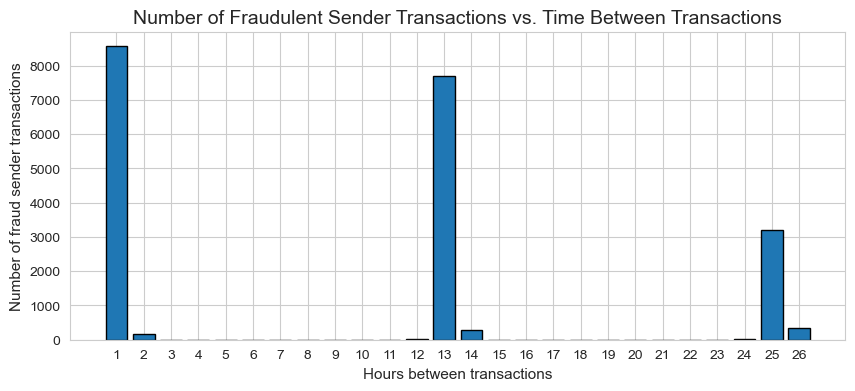

In [27]:
# Plotting distribution of sender fraud counts in hours after transaction
trans_btwn_counts = np.zeros(26)

for i in np.arange(26):
    trans_btwn_counts[i] = JPfraud[((JPfraud.sender_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.sender_time_btwn < dt.timedelta(hours=float(i+1))))].Label.sum()

plt.figure(figsize=(10,4))
plt.bar(np.linspace(1,26,26), trans_btwn_counts, edgecolor='black')
plt.xlabel('Hours between transactions',fontsize=11)
plt.ylabel('Number of fraud sender transactions',fontsize=11)
plt.title('Number of Fraudulent Sender Transactions vs. Time Between Transactions',fontsize=14)
plt.xticks(np.arange(26)+1)
plt.savefig('sender_hrs_after_fraud.png')
plt.show()

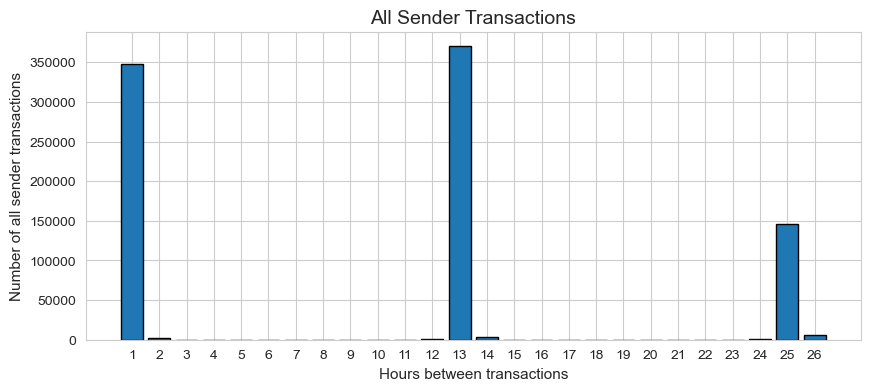

In [28]:
# Plotting distribution of sender fraud counts in hours after transaction
all_trans_btwn_counts = np.zeros(26)

for i in np.arange(26):
    all_trans_btwn_counts[i] = len(JPfraud[((JPfraud.sender_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.sender_time_btwn < dt.timedelta(hours=float(i+1))))])

plt.figure(figsize=(10,4))
plt.bar(np.linspace(1,26,26), all_trans_btwn_counts, edgecolor='black')
plt.xlabel('Hours between transactions',fontsize=11)
plt.ylabel('Number of all sender transactions',fontsize=11)
plt.xticks(np.arange(26)+1)
plt.title('All Sender Transactions',fontsize=14)
plt.savefig('sender_hrs_btwn_all_transactions.png')
plt.show()


In [ ]:
# Number of bene fraudulent transactions within 24 hours (inclusive) of a transaction
print('Number of bene frauds within first hour after transaction: ', JPfraud[JPfraud.bene_time_btwn <= dt.timedelta(hours=1)].Label.sum())
print('Number of bene frauds within 25 hours after transaction: ', JPfraud[JPfraud.bene_time_btwn <= dt.timedelta(hours=25)].Label.sum())
print('Number of bene frauds over 25 hours after transaction: ', JPfraud[JPfraud.bene_time_btwn > dt.timedelta(hours=25)].Label.sum())

In [ ]:
trans_btwn_counts

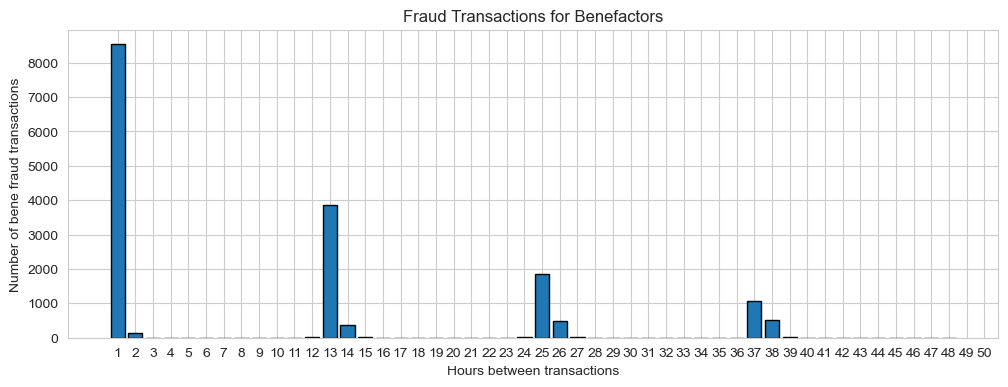

In [29]:
# Plotting distribution of bene fraud counts in hours after transaction
trans_btwn_bene_counts = np.zeros(48)

for i in np.arange(48):
    trans_btwn_bene_counts[i] = JPfraud[((JPfraud.bene_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.bene_time_btwn < dt.timedelta(hours=float(i+1))))].Label.sum()

plt.figure(figsize=(12,4))
plt.bar(np.linspace(1,48,48), trans_btwn_bene_counts, edgecolor='black')
plt.xlabel('Hours between transactions')
plt.ylabel('Number of bene fraud transactions')
plt.xticks(np.arange(50)+1)
plt.title('Fraud Transactions for Benefactors')
plt.savefig('bene_hrs_btwn_all_transactions.png')
plt.show()

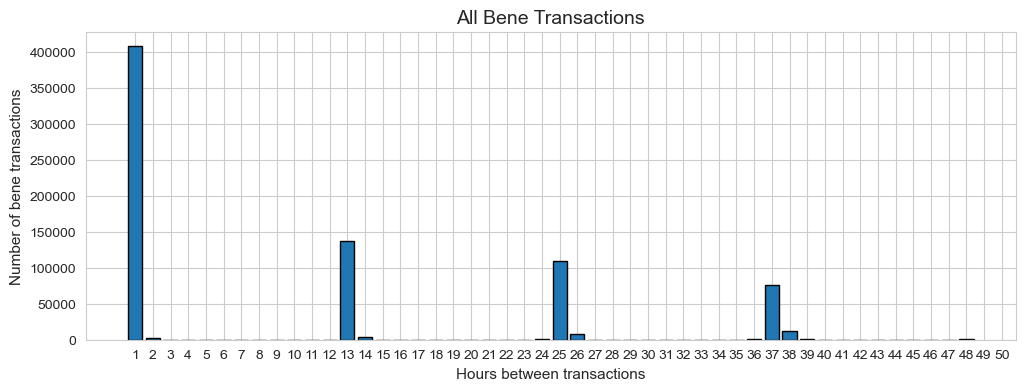

In [30]:
# Plotting distribution of bene fraud counts in hours after transaction
trans_btwn_all_bene_counts = np.zeros(48)

for i in np.arange(48):
    trans_btwn_all_bene_counts[i] = len(JPfraud[((JPfraud.bene_time_btwn >= dt.timedelta(hours=float(i))) &
                                    (JPfraud.bene_time_btwn < dt.timedelta(hours=float(i+1))))])

plt.figure(figsize=(12,4))
plt.bar(np.linspace(1,48,48), trans_btwn_all_bene_counts, edgecolor='black')
plt.xlabel('Hours between transactions',fontsize=11)
plt.ylabel('Number of bene transactions',fontsize=11)
plt.xticks(np.arange(50)+1)
plt.title('All Bene Transactions',fontsize=14)
plt.savefig('bene_hrs_btwn_all_transactions.png')
plt.show()

In [ ]:
trans_btwn_bene_counts

In [ ]:
JPfraud.bene_time_btwn.describe()

In [ ]:
# Number of fraud, bene transactions vs time between last transactions, 10-minute distribution (first 4 hours)
JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('30min').Label.count().head(30)

In [ ]:
JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('1D').Label.count()

In [ ]:
JPfraud[JPfraud.Label == 0].set_index('bene_time_btwn').resample('1D').Label.count()

In [ ]:
timeDiffcompare = pd.concat([JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('1D').Label.count(),
                             JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('1D').Label.count()],
                             keys=['sender_time_btwn','bene_time_btwn'],
                             axis=1).fillna(0)
timeDiffcompare.index = timeDiffcompare.index.days
timeDiffcompare

In [ ]:
plt.figure(figsize=(20,10))
timeDiffcompare.plot.bar(stacked=True,width=1)
plt.xticks(fontsize=6,rotation=0)
plt.xlabel('Days between transactions')
plt.ylabel('Number of fraud transactions')
plt.show()

<font size=5> Generating time/time range features </font>

In [ ]:
# Functions to convert between seconds and a time object
def convert_time_to_seconds(timeObj):
    return int((timeObj.hour)*60*60 + (timeObj.minute)*60 + (timeObj.second))

#def convert_seconds_to_time(seconds):
#    if pd.isna(seconds):
#        return pd.NA
#    
#    hour = int(seconds / 3600)
#    mins = int((seconds % 3600)/60)
#    secs = (seconds % 3600) % 60
#
#    return dt.time(hour,mins,secs)

In [ ]:
np.linspace(0.75,1,26)

In [ ]:
pd.options.mode.chained_assignment = None
start = dt.datetime.now()

# Choosing quantile percentages
lower_time_quantile = 0.15
upper_time_quantile = 0.85

# seconds_in_day: time transaction occurred in seconds after midnight
JPfraud['seconds_in_day'] = JPfraud.timestamp.transform(lambda x: float(convert_time_to_seconds(x.time())))

# time_min_out: rolling lower quantile for range of time of SENDER transactions (in seconds after midnight)
JPfraud['time_min_out'] = (JPfraud.groupby('Sender_Account')['seconds_in_day']
                                  .apply(lambda x: x.expanding(method='single',min_periods=min_obs)
                                                    .quantile(q=lower_time_quantile,interpolation='midpoint'))
                                  .reset_index(level=0,drop=True)
                          )

# time_max_out: rolling upper quantile for range of time of SENDER transactions (in seconds after midnight)
JPfraud['time_max_out'] = (JPfraud.groupby('Sender_Account')['seconds_in_day']
                                  .apply(lambda x: x.expanding(method='single',min_periods=min_obs)
                                                    .quantile(q=upper_time_quantile,interpolation='midpoint'))
                                  .reset_index(level=0,drop=True)
                          )

# time_min_in: rolling lower quantile for range of time of BENEFICIARY transactions (in seconds after midnight)
JPfraud['time_min_in'] = (JPfraud.groupby('Bene_Account')['seconds_in_day']
                                 .apply(lambda x: x.expanding(method='single',min_periods=min_obs)
                                                   .quantile(q=lower_time_quantile,interpolation='midpoint'))
                                 .reset_index(level=0,drop=True)
                         )

# time_max_in: rolling upper quantile for range of time of BENEFICIARY transactions (in seconds after midnight)
JPfraud['time_max_in'] = (JPfraud.groupby('Bene_Account')['seconds_in_day']
                                 .apply(lambda x: x.expanding(method='single',min_periods=min_obs)
                                                   .quantile(q=upper_time_quantile,interpolation='midpoint'))
                                 .reset_index(level=0,drop=True)
                         )

# outside_time_bene_range:   indicator of whether transaction is outside range for beneficiary at
#                            time of transaction, 0 no, 1 yes
JPfraud = JPfraud.assign(outside_time_bene_range = lambda x: ((x.seconds_in_day < x.time_min_in) | (x.seconds_in_day > x.time_max_in))*1)

# outside_time_sender_range: indicator of whether transaction is outside usual time range for sender
#                            at time of transaction, 0 no, 1 yes
JPfraud = JPfraud.assign(outside_time_sender_range = lambda x: ((x.seconds_in_day < x.time_min_out) | (x.seconds_in_day > x.time_max_out))*1)

JPfraud

In [ ]:
time_features = JPfraud[['timestamp','Label','seconds_in_day','outside_time_bene_range','outside_time_sender_range']]
time_features

In [ ]:
def label_time_range(seconds):
    return int(seconds/3600) + 1

In [ ]:
# transaction_hour: hour of transaction within a day
time_features['transaction_hour'] = time_features.seconds_in_day.apply(label_time_range)
time_features

In [ ]:
(time_features[time_features.Label == 1].outside_time_bene_range.sum() +
time_features[time_features.Label == 1].outside_time_sender_range.sum())/len(time_features[time_features.Label == 1])

In [ ]:
(time_features.outside_time_bene_range.sum() + time_features.outside_time_sender_range.sum())/len(time_features)

In [ ]:
#time_features.to_csv('data/time_features.csv')

In [ ]:
time_features[time_features.Label == 1].groupby('transaction_hour').Label.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of frauds')
plt.ylim([0,700])
plt.show()

In [ ]:
time_features[time_features.outside_time_bene_range == 1].groupby('transaction_hour').outside_time_bene_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of outside time range IN transactions')
plt.ylim([0,14000])
plt.show()

In [ ]:
time_features[time_features.outside_time_sender_range == 1].groupby('transaction_hour').outside_time_sender_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of outside time range OUT transactions')
#plt.ylim([0,14000])
plt.show()

In [ ]:
time_features[((time_features.outside_time_sender_range == 1) & (time_features.Label == 1))].groupby(
    'transaction_hour').outside_time_sender_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of fraudulent outside time range OUT transactions')
#plt.ylim([0,14000])
plt.show()

In [ ]:
time_features[((time_features.outside_time_bene_range == 1) & (time_features.Label == 1))].groupby(
    'transaction_hour').outside_time_bene_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of fraudulent outside time range IN transactions')
#plt.ylim([0,14000])
plt.show()

In [ ]:
#JPfraud.loc[JPfraud.Sender_Id == sendIDs[9]].USD_amount.agg('describe')[['std','min','25%','50%','mean','75%','max']].values

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
#sender_fraud_stat_amounts = JPfraud.loc[JPfraud.Label == 1].groupby(
#    'Sender_Id').USD_amount.agg('describe')[['std','min','25%','50%','mean','75%','max']].reset_index()
#sender_fraud_stat_amounts

In [ ]:
JPfraud[JPfraud.Bene_Id == 'CLIENT-725719'].outside_time_bene_range.sum()

In [ ]:
JPfraud[JPfraud.Bene_Id == 'CLIENT-725719'].Label.sum()

In [ ]:
JPfraud[JPfraud.Sender_Account == 'ACCOUNT-9825']

<font size=5> Adding Abdullah's features to test run a logistic model on training data</font>

In [ ]:
JPfraud_fit = JPfraud[:465008].loc[JPfraud.USD_amount > 0].reset_index(drop=True)
JPfraud_fit

In [ ]:
# columns to drop for model fitting
columns_to_drop = ['seconds_in_day','time_min_in','time_max_in','time_min_out','time_max_out',
                   'rolling_sender_trans_min','rolling_sender_trans_max','rolling_bene_trans_min',
                   'rolling_bene_trans_max','rolling_sender_time_diff_min','rolling_sender_time_diff_max',
                   'rolling_bene_time_diff_min','rolling_bene_time_diff_max','sender_time_btwn','bene_time_btwn',
                   'timestamp','Transaction_Id','Sender_Id','Sender_Account','Sender_Country','Bene_Id',
                   'USD_amount','Bene_Account','Bene_Country','Transaction_Type']

In [ ]:
JPfraud_fit = JPfraud_fit.drop(labels=columns_to_drop,axis=1)
JPfraud_fit

In [ ]:
more_features = pd.read_csv('../data/Total_engineered_features')
more_features

In [ ]:
more_features = more_features.drop(columns=['Quick'])

In [ ]:
JPfraud_fit = pd.concat([JPfraud_fit,more_features],axis=1)
JPfraud_fit

In [ ]:
JPfraud_fit.columns

In [ ]:
num_features = ['bene_prob','Fraud_percentage_bene','Fraud_index_bene','sender_prob',
                'Fraud_percentage_sender','Fraud_index_sender']
cat_features = ['out_sender_trans_range','out_bene_trans_range','out_sender_time_diff_range',
                'out_bene_time_diff_range','outside_time_bene_range','outside_time_sender_range','New',
                'Repeat_Fraud','Quick','Transaction_Type_DEPOSIT-CASH','Transaction_Type_DEPOSIT-CHECK',
                'Transaction_Type_EXCHANGE','Transaction_Type_MAKE-PAYMENT', 'Transaction_Type_MOVE-FUNDS',
                'Transaction_Type_PAY-CHECK','Transaction_Type_QUICK-PAYMENT','Transaction_Type_WITHDRAWAL']

In [ ]:
print(len(JPfraud_fit.columns))
print(len(num_features))
print(len(cat_features))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix, classification_report, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(JPfraud_fit.drop(columns=['Label'],axis=1),JPfraud_fit.Label,test_size=0.2,random_state=12345)

In [ ]:
log_reg = LogisticRegression()
y = JPfraud_fit.Label

log_reg.fit(X_train,y_train)
Label_preds = log_reg.predict(X_test)

print('Coeffs: ',log_reg.coef_)
print('Intercept: ', log_reg.intercept_)
print('Score: ', log_reg.score(JPfraud_fit.drop(labels=['Label'],axis=1),y))
print(classification_report(y_test, Label_preds))

In [ ]:
confusion_matrix(y_test,Label_preds, normalize='true').round(3)

In [ ]:
cm = confusion_matrix(y_test, Label_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix')
plt.show()

In [ ]:
total_features = pd.read_csv('../data/total_features')
total_features

In [ ]:
len(total_features.columns)

In [ ]:
total_features.columns

In [ ]:
plt.figure(figsize=(12, 12)) 
ax = sns.heatmap(pd.concat([total_features,JPfraud_full['Label']],axis=1).corr(),
        annot=True,         # Display correlation values on the heatmap
        cmap='coolwarm',    # Choose a divergent colormap (e.g., 'coolwarm', 'RdBu')
        fmt=".2f",          # Format annotation values to two decimal places
        linewidths=.5,      # Add lines between cells
        cbar=True,          # Display the color bar
        vmin=-1,            # Set the minimum value for the color scale
        vmax=1              # Set the maximum value for the color scale
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_corr_matrix.png')
plt.show()